# Projet Fraude bancaire propre : Création des modèles

In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys 
import fastparquet
from dask_ml.preprocessing import DummyEncoder
import pickle
import dask_ml 
from dask import delayed
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt
from dask_ml.preprocessing import StandardScaler

# Algorithmes
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir('C:/Users/jacky/Downloads')

## I. Importation du dataset
Le pré-traitement du dataset a déjà été fait en amont. Nous importons donc directement le fichier au format dask à partir d'un format parquet.

In [3]:
df = dd.read_parquet('guillaumeb_parquet')
df.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


## II. Subdivision en apprentissage/test
 - dfTrain : du 2017-02-01 au 2017-08-31
 - dfTest : du 2017-09-01 au 2017-11-30

In [4]:
# Canger le type de la variable "CodeDecision"
df['CodeDecision'] = df['CodeDecision'].astype('object')

In [5]:
dfTrain = df.loc[df['Date'] <= '2017-08-31']
dfTest = df.loc[df['Date'] >= '2017-09-01']
dfTrain.head()

,FlagImpaye,Montant,CodeDecision,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Date,Heure
0,0,20.00,1,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,2017-02-01,07:32:14
1,0,20.00,1,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,2017-02-01,07:43:37
2,0,57.64,1,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,2017-02-01,07:47:38
3,0,54.29,0,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,2017-02-01,07:48:48
4,0,26.90,1,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,2017-02-01,08:13:27


## III. Définir la variable cible (y) et les variables explicatives (X)

In [6]:
# Définir la variable cible 
yTrain = dfTrain["FlagImpaye"]
yTest = dfTest["FlagImpaye"]

In [7]:
# Définir les variables explicatives 
XTrain = dfTrain.drop(["FlagImpaye", "Date", "Heure", "CA3TRetMtt"], axis = "columns")
XTest = dfTest.drop(["FlagImpaye", "Date", "Heure", "CA3TRetMtt"], axis = "columns")

## IV. Recodage de la variable "CodeDecision" dans les varaibles explicatives
- Rmq : La variable qualitative "CodeDecision" possède les modalités 0, 1, 2 et 3 dans dfTrain et les modalités 0, 2 et 3 dans dfTest. 
- Notre stratégie est la suivante : 
    1. Recodage de la variable "CodeDecision" dans les variables explicatives XTrain et XTest.
    2. Comme la variable "CodeDecision_1" n'est présente que dans XTrain, elle devient inutile. Nous décidons donc de la supprimer.

In [8]:
# Exposition du problème 
print("Dans le dataframe d'apprentissage :")
print(dfTrain['CodeDecision'].value_counts().compute())
print("-------------------------------------------------------")
print("Dans le dataframe de test :")
print(dfTest['CodeDecision'].value_counts().compute())

Dans le dataframe d'apprentissage :
0    2760391
1    1121626
2      15138
3       2207
Name: CodeDecision, dtype: int64
-------------------------------------------------------
Dans le dataframe de test :
0    742395
2      4424
3       591
Name: CodeDecision, dtype: int64


In [10]:
# 1) Recodage de la variable "CodeDecision" dans les variables explicatives 
XTrain_ok = dd.get_dummies(XTrain.categorize(), prefix=['CodeDecision'])
XTest_ok = dd.get_dummies(XTest.categorize(), prefix=['CodeDecision'])

# 2) Supprimer la variable "CodeDecision_1" de dfTrain
XTrain_ok = XTrain_ok.drop(["CodeDecision_1"], axis = "columns")
XTrain_ok.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
1,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0
2,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
3,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0
4,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0


## IV. Centrer-réduire les données

In [11]:
# Instanciation de StandardScaler pour centrer réduire les données
scaler = StandardScaler()

XTrain_ok_scale = scaler.fit_transform(XTrain_ok)
XTest_ok_scale = scaler.fit_transform(XTest_ok)
XTrain_ok_scale.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,-0.420302,1.017656,-0.084590,-0.239505,-0.275801,-0.030212,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.202861,-1.556786,-0.062428,-0.023797
1,-0.420302,1.017656,-0.084590,-0.239505,-0.275801,0.162138,0.818043,-0.043812,4.975724,-1.945875,-0.301229,-0.451325,0.038808,-1.556786,-0.062428,-0.023797
2,-0.022127,1.008573,-0.084590,-0.239505,-0.275801,0.562636,0.818043,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.202861,-1.556786,-0.062428,-0.023797
3,-0.057565,-0.272152,-0.084590,-0.239505,-0.275801,1.172099,0.906727,-0.043817,-0.194165,0.135329,-0.301229,-0.451325,-0.202861,0.642349,-0.062428,-0.023797
4,-0.347310,1.008573,-0.084434,0.637044,-0.273204,0.104780,0.818043,-0.043812,-0.194165,-1.757421,-0.301229,-0.451325,0.702346,-1.556786,-0.062428,-0.023797


## V. Algorithmes

In [22]:
def Calcul_CA(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable CA
    dfmerge["CA"] = dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == -1) & (dfmerge["Ypred"] == -1)), "CA"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == -1)), "CA"] = 0.8 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == -1) & (dfmerge["Ypred"] == 1)), "CA"] = 1 - np.exp(1/dfmerge["Montant"])
    
    # Calcul du CA_total
    CA_total = dfmerge["CA"].sum()
    
    return CA_total

In [267]:
"""Création de la fonction de déploiement d'un modèle sur les données de test"""

def deploiement(modele, XTest, yTest, scale):
    XTest_ = XTest
    
    scaler = StandardScaler()
    
    if scale == True:
        XTest = scaler.fit_transform(XTest)
    
    print("-------------------------------------------------------")
    # Importation du modèle 
    fichier = open(modele, "rb")
    mdl = pickle.load(fichier)
    fichier.close()
    
    # Affichage du modèle 
    print('Modèle :\n', mdl)
    print("-------------------------------------------------------")
    # Prédiction
    Ypred = delayed(mdl.predict)(XTest).compute()
    # Prédiction des scores
    Yscore = delayed(mdl.predict_proba)(XTest).compute()
    
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(yTest, Ypred)
    cr = delayed(classification_report)(yTest, Ypred)
    auc = delayed(roc_auc_score)(yTest, Ypred)

    print('Estimateurs :\n', cr.compute())
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm.compute())
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc.compute())
    print("-------------------------------------------------------")
    
    # BONUS :  Calcul du chiffre d'affaire
    CA_total = Calcul_CA(Montant = XTest_["Montant"].compute(), yReel = yTest.compute(), yPred = Ypred)
    print("Chiffre d'affaire = " + str(round(CA_total, 2)) + " euros")
    print("-------------------------------------------------------")

    # Courbe ROC
    skplt.metrics.plot_roc(yTest, Yscore, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(yTest, Yscore, classes_to_plot = 1, plot_micro = False)
    return CA_total

# ALGORITHMES NON-SUPERVISES

## -------- Algorithme n°8 : SGD ONE CLASS SVM --------¶

Nous allons tester le modèle en recherchant d'abord les meilleurs paramètres parmis une sélection.
L'hyperparamètre 'nu' doit correspondre à la proportion d'outliers (ici, les fraudes) dans le jeu de données. Dans notre cas il est connu donc nous pouvons le fixer à 0.0065, mais nous allons également tester avec différentes valeurs pour mesurer la robustesse du modèle.

Nous associons une approximation de kernel à l'algorithme avec Nystroem, pour avoir des résultats proches du One Class SVM classique qui n'est pas adapté aux grands jeux de données. Nous allons comparer les kernels suivants : 

- Radial : RBF
- Polynomial de degré 5
- Sigmoid

Deux stratégies sont utilisées et comparées : 

- Outliers detection : le modèle est entraîné sur les deux classes. Il va apprendre à reconnaître ce qu'est un outlier pour le détecter dans l'échantillon test.

- Novelty detection : approche semi-supervisée, le modèle ne sera entraîné que sur la classe majoritaire. Puis il réalisera les prédictions sur l'échantillon test contenant les deux classes. Les individus de la classe frauduleuse devraient être détectés comme "différents" par le modèle.

### Préparation des données

In [12]:
# On recode en -1 et 1 pour les besoins de ces algorithmes qui affectent un score de -1 ou 1
yTrain = yTrain.replace({1: -1, 0 : 1})
yTest = yTest.replace({1: -1, 0 : 1})

In [13]:
# Train set avec la classe 0 uniquement
df_0 = df[df['FlagImpaye'] == 0]
XTrain_0 = df_0.loc[df['Date'] <= '2017-08-31']
XTrain_0 = XTrain_0.drop(["FlagImpaye", "Date", "Heure", "CA3TRetMtt"], axis = "columns")

# Recodage de la variable "CodeDecision" dans les variables explicatives 
XTrain_0 = dd.get_dummies(XTrain_0.categorize(), prefix=['CodeDecision'])

# Supprimer la variable "CodeDecision_1" 
XTrain_0 = XTrain_0.drop(["CodeDecision_1"], axis = "columns")
XTrain_0.head()

,Montant,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TR,CodeDecision_0,CodeDecision_2,CodeDecision_3
0,20.00,551,0.000000,0.000000,0.000000,37.186668,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
1,20.00,551,0.000000,0.000000,0.000000,48.844716,52.076034,1,2,1.797685,4.0,4.0,8.61,0,0,0
2,57.64,549,0.000000,0.000000,0.000000,73.118280,52.076034,0,1,4.000000,4.0,4.0,0.00,0,0,0
3,54.29,267,0.000000,0.000000,0.000000,110.056926,53.554234,0,1,4.000000,4.0,4.0,0.00,1,0,0
4,26.90,549,0.003769,8.586333,0.001192,45.368313,52.076034,1,1,1.997106,4.0,4.0,32.25,0,0,0


In [14]:
# Centrage-Réduction des données ne comprenant que la classe non frauduleuse dans l'échantillon d'entraînement
scaler_0 = StandardScaler()
XTrain_0_scale = scaler_0.fit_transform(XTrain_0)
XTest_0_scale = scaler_0.transform(XTest_ok)

# Centrage-Réduction des données comprenant les deux classes dans l'échantillon d'entraînement
scaler = StandardScaler()
XTrain_ok_scale = scaler.fit_transform(XTrain_ok)
XTest_ok_scale = scaler.transform(XTest_ok)

In [15]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

## Outliers detection

On entraîne le modèle sur les deux classes. 
Dans premier temps, on entraîne le modèle sans kernel. On fixe le paramètre nu à 0.0065.
On utilise pour cet algorithme les données centrées et réduites.

In [65]:
# Modèle
osvm_linear = linear_model.SGDOneClassSVM(nu = 0.0065, max_iter = 2000, tol=1e-7, warm_start=False, random_state = 2, shuffle = True)
  
# Entraînement
fit_osvm_linear = delayed(osvm_linear.fit)(XTrain_ok_scale)

# Prédiction
pred_osvm_linear = delayed(fit_osvm_linear.predict)(XTest_ok_scale)
y_pred_OSVM_linear = pred_osvm_linear.compute()

# Matrice de confusion
cm_osvm_linear = delayed(confusion_matrix)(yTest, y_pred_OSVM_linear).compute()
print(cm_osvm_linear)

# Métriques
classif_osvm = delayed(classification_report)(yTest, y_pred_OSVM_linear).compute()
print(classif_osvm)

# AUC score
print(round(roc_auc_score(yTest, y_pred_OSVM_linear), 4))

array([[    13,   6560],
       [  2895, 737942]], dtype=int64)

Les résultats ne sont pas satisfaisants. Ces données ne semblent pas être linéairement séparables. 
Nous allons donc utiliser des kernels.

On teste dans un premier temps avec un kernel polynomial de degré 5.

In [102]:
osvm_kernel = linear_model.SGDOneClassSVM(nu = 0.0065, shuffle=True, fit_intercept=True, random_state= 2, tol=1e-7, max_iter = 2000)

# Kernel approximation

transform = Nystroem(kernel = 'poly', gamma=0.0005, n_components = 25, random_state = 2, degree = 5, coef0 = None)
pipeline_osvm = make_pipeline(transform, osvm_kernel)

# Entraînement
fit_osvm_kernel = delayed(pipeline_osvm.fit)(XTrain_ok_scale)

# Prédiction
pred_osvm_kernel = delayed(fit_osvm_kernel.predict)(XTest_ok_scale)
y_pred_osvm_kernel = pred_osvm_kernel.compute()

# Matrice de confusion
cm_osvm_kernel = delayed(confusion_matrix)(yTest, y_pred_osvm_kernel).compute()
cm_osvm_kernel

array([[  3336,   3237],
       [  1990, 738847]], dtype=int64)

Le modèle, sans être excellent en rappel et précision, est bien plus performant que le précédent.
L'expansion de base semble être une bonne piste sur laquelle nous allons poursuivre.

Nous créons une fonction permettant de comparer différentes combinaisons de paramètres sans passer par une validation croisée inadaptée dans notre contexte.

- Paramètre nu compris entre 0.0065 et 0.015
- Paramètre gamma entre 0.0001 et 0.1
- Paramètre n_components entre 5 et 25 : nombre de dimensions du nouvel espace


In [124]:
def Model_OneClassSVM(X_train, X_test, yTest, kernel, degree = None):    
    
    # Hyperparamètres
    nu = [0.0065, 0.08, 0.01, 0.015]
    gamma = [0.1, 0.05, 0.01, 0.005, 0.0005, 0.0001]
    n_components = [5, 15, 25]
    
    # Instanciation pour le stockage des résultats de performance
    results_osvm = []

    # Tests de toutes les combinaisons
    for i in nu:
        for j in gamma:
            for l in n_components:
                # Instanciation du modèle avec la kernel approximation     
                osvm = linear_model.SGDOneClassSVM(nu=i, shuffle=True, fit_intercept=True, random_state=2, tol=1e-7, max_iter = 2000)
                transform = Nystroem(kernel = kernel, gamma=j, n_components = l, random_state=2, degree = degree, n_jobs = -2)

                # Pipeline
                pipeline_osvm = make_pipeline(transform, osvm)

                # Entraînement
                fit_osvm = delayed(pipeline_osvm.fit)(X_train)

                # Prédiction
                pred_osvm = delayed(fit_osvm.predict)(X_test)
                y_pred_osvm = pred_osvm.compute()
                
                # Matrice de confusion
                cm_osvm = delayed(confusion_matrix)(yTest, y_pred_osvm).compute()

                # Stockage des résultats de performance
                results_osvm.append({'Vrais positifs' : cm_osvm[0][0],
                                     'Faux négatifs' : cm_osvm[0][1],
                                     'Faux positifs' : cm_osvm[1][0],
                                     'Vrais negatifs' : cm_osvm[1][1],
                                     'Accuracy' : delayed(accuracy_score)(yTest, y_pred_osvm).compute(),
                                     'Precision classe 1' : delayed(precision_score)(yTest, y_pred_osvm, pos_label = -1, average= 'binary', labels=np.unique(y_pred_osvm)).compute(),
                                     'Precision classe 0' : delayed(precision_score)(yTest, y_pred_osvm, pos_label = 1, average= 'binary', labels=np.unique(y_pred_osvm)).compute(),
                                     'Rappel classe 1' : delayed(recall_score)(yTest, y_pred_osvm, pos_label = -1, average= 'binary').compute(),
                                     'Rappel classe 0' : delayed(recall_score)(yTest, y_pred_osvm, pos_label = 1, average= 'binary').compute(),
                                     'f1-score classe 1' : delayed(f1_score)(yTest, y_pred_osvm, pos_label = -1, average= 'binary').compute(),
                                     'f1-score classe 0' : delayed(f1_score)(yTest, y_pred_osvm, pos_label = 1, average= 'binary').compute(),
                                     'roc_auc_score' : round(roc_auc_score(yTest, y_pred_osvm), 4),
                                     'nu' : i,
                                     'gamma' : j,
                                     'n_components' : l
                                   })

    # Conversion en DataFrame
    results_osvm = pd.DataFrame(results_osvm)
    results_osvm = results_osvm.sort_values(by='f1-score classe 1', ascending=False)
    return results_osvm

#### Fonction de déploiement pour One Class SVM et Isolation Forest

In [23]:
"""Création de la fonction de déploiement d'un modèle sur les données de test"""

def deploiement_unsupervised(modele, XTest, yTest, scale, X_ca):
    XTest_ = XTest
    
    scaler = StandardScaler()
    
    if scale == True:
        XTest = scaler.fit_transform(XTest)
    
    print("-------------------------------------------------------")
    # Importation du modèle 
    fichier = open(modele, "rb")
    mdl = pickle.load(fichier)
    fichier.close()
    
    # Affichage du modèle 
    print('Modèle :\n', mdl)
    print("-------------------------------------------------------")
    # Prédiction
    Ypred = delayed(mdl.predict)(XTest).compute()
    #Ypred = [1 if x == -1 else 0 for x in Ypred]
    # Prédiction des scores
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(yTest, Ypred)
    cr = delayed(classification_report)(yTest, Ypred)
    auc = delayed(roc_auc_score)(yTest, Ypred)

    print('Estimateurs :\n', cr.compute())
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm.compute())
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc.compute())
    print("-------------------------------------------------------")
    
    # BONUS :  Calcul du chiffre d'affaire
    CA_total = Calcul_CA(Montant = X_ca["Montant"].compute(), yReel = yTest.compute(), yPred = Ypred)
    print("Chiffre d'affaire = " + str(round(CA_total, 2)) + " euros")
    print("-------------------------------------------------------")
    
    
    return CA_total

### Kernel Radial

On teste les paramètres avec un kernel radial : RDF

In [107]:
%time Results_rbf = Model_OneClassSVM(X_train = XTrain_ok_scale, X_test = XTest_ok_scale, yTest = yTest, kernel = 'rbf')

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Wall time: 50min 8s


In [115]:
Results_rbf.head(10)

,Vrais positifs,Faux négatifs,Faux positifs,Vrais negatifs,Accuracy,Precision classe 1,Precision classe 0,Rappel classe 1,Rappel classe 0,f1-score classe 1,f1-score classe 0,roc_auc_score,nu,gamma,n_components
16,4234,2339,2785,738052,0.993144,0.603220,0.996841,0.644150,0.996241,0.623014,0.996541,0.8202,0.0065,0.0001,"[5, 15, 25]"
17,4096,2477,2700,738137,0.993073,0.602707,0.996655,0.623155,0.996355,0.612761,0.996505,0.8098,0.0065,0.0001,"[5, 15, 25]"
14,4011,2562,2757,738080,0.992883,0.592642,0.996541,0.610224,0.996279,0.601304,0.996410,0.8033,0.0065,0.0005,"[5, 15, 25]"
3,4564,2009,4105,736732,0.991820,0.526474,0.997281,0.694356,0.994459,0.598872,0.995868,0.8444,0.0065,0.0500,"[5, 15, 25]"
13,3977,2596,2826,738011,0.992746,0.584595,0.996495,0.605051,0.996185,0.594647,0.996340,0.8006,0.0065,0.0005,"[5, 15, 25]"
8,3915,2658,3050,737787,0.992363,0.562096,0.996410,0.595618,0.995883,0.578372,0.996147,0.7958,0.0065,0.0100,"[5, 15, 25]"
4,4587,1986,5330,735507,0.990212,0.462539,0.997307,0.697855,0.992805,0.556337,0.995051,0.8453,0.0065,0.0500,"[5, 15, 25]"
5,4588,1985,5356,735481,0.990178,0.461384,0.997308,0.698007,0.992770,0.555549,0.995034,0.8454,0.0065,0.0500,"[5, 15, 25]"
11,3647,2926,3006,737831,0.992063,0.548174,0.996050,0.554846,0.995942,0.551489,0.995996,0.7754,0.0065,0.0050,"[5, 15, 25]"
52,4598,1975,5585,735252,0.989885,0.451537,0.997321,0.699528,0.992461,0.548818,0.994885,0.8460,0.0100,0.0001,"[5, 15, 25]"


### Création du modèle à kernel radial

Nous prenons les paramètres du modèle ayant le meilleur f1-score sur la classe frauduleuse. On voit cependant que les meilleurs résultats sont assez proches. Le paramètres nu = 0.0065 et gamma = 0.0001 donnent les meilleurs résultats.
Les performances sont tout de même assez médiocres avec une précision et un rappel de 60% et 62% respectivement pour la classe frauduleuse.

In [408]:
# Instanciation du modèle ayant les meilleures performances
osvm = linear_model.SGDOneClassSVM(nu=0.0065, 
                                   fit_intercept=True, 
                                   random_state=2, 
                                   tol=1e-7, 
                                   max_iter = 2000)

# Kernel approximation
transform = Nystroem(kernel = 'rbf', 
                     gamma= 0.0001, 
                     n_components = 15, 
                     random_state=2, 
                     degree = None, 
                     n_jobs = -2)

# Pipeline
pipeline_osvm = make_pipeline(transform, osvm)

# Structure de l'entrainement
fit_osvm = delayed(pipeline_osvm.fit)(XTrain_ok_scale)

In [409]:
# Création du modèle entrainé 
model_fit = fit_osvm.compute()
print(model_fit)

Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.0001, n_components=15, n_jobs=-2,
                          random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.0065, random_state=2,
                                tol=1e-07))])


In [410]:
# Exportation du modèle 
f = open("modele8_rbf.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### Déploiement du modèle

In [24]:
dep8 = deploiement_unsupervised(modele = "modele8_rbf.sav", XTest = XTest_ok_scale, yTest = yTest, X_ca = XTest_ok, scale = False)

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.0001, n_components=15, n_jobs=-2,
                          random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.0065, random_state=2,
                                tol=1e-07))])
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

          -1       0.60      0.64      0.62      6573
           1       1.00      1.00      1.00    740837

    accuracy                           0.99    747410
   macro avg       0.80      0.82      0.81    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[  4234   2339]
 [  2785 738052]]
-------------------------------------------------------
Auc Score :
 0.8201955251989856
-------------------------------------

### Kernel Polynomial de degré 5

Testons maintenant avec le kernel polynomial de degré 5

In [108]:
%time Results_polynomial = Model_OneClassSVM(X_train = XTrain_ok_scale, X_test = XTest_ok_scale, yTest = yTest, kernel = 'poly', degree = 5)

Wall time: 48min 58s


In [116]:
Results_polynomial.head(10)

,Vrais positifs,Faux négatifs,Faux positifs,Vrais negatifs,Accuracy,Precision classe 1,Precision classe 0,Rappel classe 1,Rappel classe 0,f1-score classe 1,f1-score classe 0,roc_auc_score,nu,gamma,n_components
71,4291,2282,1494,739343,0.994948,0.741746,0.996923,0.652822,0.997983,0.694449,0.997453,0.8254,0.0150,0.0001,"[5, 15, 25]"
70,4283,2290,2435,738402,0.993678,0.637541,0.996908,0.651605,0.996713,0.644496,0.996811,0.8242,0.0150,0.0001,"[5, 15, 25]"
67,4287,2286,2859,737978,0.993116,0.599916,0.996912,0.652214,0.996141,0.624973,0.996526,0.8242,0.0150,0.0005,"[5, 15, 25]"
17,3540,3033,1276,739561,0.994235,0.735050,0.995916,0.538567,0.998278,0.621652,0.997095,0.7684,0.0065,0.0001,"[5, 15, 25]"
49,3837,2736,2337,738500,0.993213,0.621477,0.996309,0.583752,0.996845,0.602024,0.996577,0.7903,0.0100,0.0005,"[5, 15, 25]"
52,3818,2755,2429,738408,0.993064,0.611173,0.996283,0.580861,0.996721,0.595632,0.996502,0.7888,0.0100,0.0001,"[5, 15, 25]"
14,3336,3237,1990,738847,0.993007,0.626361,0.995638,0.507531,0.997314,0.560719,0.996475,0.7524,0.0065,0.0005,"[5, 15, 25]"
16,2927,3646,1448,739389,0.993184,0.669029,0.995093,0.445307,0.998045,0.534710,0.996567,0.7217,0.0065,0.0001,"[5, 15, 25]"
7,3303,3270,3590,737247,0.990822,0.479182,0.995584,0.502510,0.995154,0.490569,0.995369,0.7488,0.0065,0.0100,"[5, 15, 25]"
11,3229,3344,3681,737156,0.990601,0.467294,0.995484,0.491252,0.995031,0.478974,0.995258,0.7431,0.0065,0.0050,"[5, 15, 25]"


### Création du modèle à kernel polynomial

Les meilleurs modèles sont bien plus performants que les précédents en kernel radial.

In [389]:
# Instanciation du modèle ayant les meilleures performances
osvm = linear_model.SGDOneClassSVM(nu=0.015, 
                                   fit_intercept=True, 
                                   random_state=2, 
                                   tol=1e-7, 
                                   max_iter = 2000)

# Kernel approximation
transform = Nystroem(kernel = 'poly', 
                     gamma= 0.0001, 
                     n_components = 25, 
                     random_state=2, 
                     degree = 5, 
                     n_jobs = -2)

# Pipeline
pipeline_osvm = make_pipeline(transform, osvm)

# Structure de l'entrainement
fit_osvm = delayed(pipeline_osvm.fit)(XTrain_ok_scale)

In [390]:
# Création du modèle entrainé 
model_fit = fit_osvm.compute()
print(model_fit)

Pipeline(steps=[('nystroem',
                 Nystroem(degree=5, gamma=0.0001, kernel='poly',
                          n_components=25, n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.015, random_state=2,
                                tol=1e-07))])


In [391]:
# Exportation du modèle 
f = open("modele8_poly.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### Déploiement du modèle

In [25]:
dep9 = deploiement_unsupervised(modele = "modele8_poly.sav", XTest = XTest_ok_scale, yTest = yTest, X_ca = XTest_ok, scale = False)

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('nystroem',
                 Nystroem(degree=5, gamma=0.0001, kernel='poly',
                          n_components=25, n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.015, random_state=2,
                                tol=1e-07))])
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

          -1       0.74      0.65      0.69      6573
           1       1.00      1.00      1.00    740837

    accuracy                           0.99    747410
   macro avg       0.87      0.83      0.85    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[  4291   2282]
 [  1494 739343]]
-------------------------------------------------------
Auc Score :
 0.8254027566434036
-------------

### Kernel sigmoid

In [ ]:
%time Results_sigmoid = Model_OneClassSVM(X_train = XTrain_ok_scale, X_test = XTest_ok_scale, yTest = yTest, kernel = 'sigmoid')

In [401]:
Results_sigmoid.head(10)

,Vrais positifs,Faux négatifs,Faux positifs,Vrais negatifs,Accuracy,Precision classe 1,Precision classe 0,Rappel classe 1,Rappel classe 0,f1-score classe 1,f1-score classe 0,roc_auc_score,nu,gamma,n_components
71,4288,2285,1403,739434,0.995066,0.753470,0.996919,0.652366,0.998106,0.699282,0.997512,0.8252,0.0150,0.0001,"[5, 15, 25]"
68,4280,2293,1612,739225,0.994775,0.726409,0.996908,0.651149,0.997824,0.686723,0.997366,0.8245,0.0150,0.0005,"[5, 15, 25]"
53,4128,2445,1324,739513,0.994957,0.757153,0.996705,0.628024,0.998213,0.686570,0.997458,0.8131,0.0100,0.0001,"[5, 15, 25]"
50,4012,2561,1418,739419,0.994676,0.738858,0.996548,0.610376,0.998086,0.668500,0.997317,0.8042,0.0100,0.0005,"[5, 15, 25]"
70,4295,2278,2048,738789,0.994212,0.677124,0.996926,0.653431,0.997236,0.665067,0.997081,0.8253,0.0150,0.0001,"[5, 15, 25]"
17,3833,2740,1201,739636,0.994727,0.761422,0.996309,0.583143,0.998379,0.660464,0.997343,0.7908,0.0065,0.0001,"[5, 15, 25]"
35,4491,2082,2555,738282,0.993796,0.637383,0.997188,0.683250,0.996551,0.659520,0.996869,0.8399,0.0800,0.0001,"[5, 15, 25]"
52,3961,2612,1760,739077,0.994150,0.692361,0.996478,0.602617,0.997624,0.644379,0.997051,0.8001,0.0100,0.0001,"[5, 15, 25]"
16,3670,2903,1406,739431,0.994235,0.723010,0.996089,0.558345,0.998102,0.630097,0.997095,0.7782,0.0065,0.0001,"[5, 15, 25]"
49,3772,2801,1782,739055,0.993868,0.679150,0.996224,0.573863,0.997595,0.622083,0.996909,0.7857,0.0100,0.0005,"[5, 15, 25]"


### Création du modèle à kernel sigmoid

In [403]:
# Instanciation du modèle ayant les meilleures performances
osvm = linear_model.SGDOneClassSVM(nu=0.015, 
                                   fit_intercept=True, 
                                   random_state=2, 
                                   tol=1e-7, 
                                   max_iter = 2000)

# Kernel approximation
transform = Nystroem(kernel = 'sigmoid', 
                     gamma= 0.0001, 
                     n_components = 25, 
                     random_state=2, 
                     degree = None, 
                     n_jobs = -2)

# Pipeline
pipeline_osvm = make_pipeline(transform, osvm)

# Structure de l'entrainement
fit_osvm = delayed(pipeline_osvm.fit)(XTrain_ok_scale)

In [404]:
# Création du modèle entrainé 
model_fit = fit_osvm.compute()
print(model_fit)

Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.0001, kernel='sigmoid', n_components=25,
                          n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.015, random_state=2,
                                tol=1e-07))])


In [405]:
# Exportation du modèle 
f = open("modele8_sigmoid.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### Déploiement du modèle

In [26]:
dep10 = deploiement_unsupervised(modele = "modele8_sigmoid.sav", XTest = XTest_ok_scale, yTest = yTest, X_ca = XTest_ok, scale = False)

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.0001, kernel='sigmoid', n_components=25,
                          n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.015, random_state=2,
                                tol=1e-07))])
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

          -1       0.75      0.65      0.70      6573
           1       1.00      1.00      1.00    740837

    accuracy                           1.00    747410
   macro avg       0.88      0.83      0.85    747410
weighted avg       0.99      1.00      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[  4288   2285]
 [  1403 739434]]
-------------------------------------------------------
Auc Score :
 0.8252359673637683
--------------------

In [114]:
Results_rbf.to_csv("C:/Users/jacky/OneDrive/Bureau/OSVM_RBF.csv")
Results_polynomial.to_csv("C:/Users/jacky/OneDrive/Bureau/OSVM_POLY.csv")
Results_sigmoid.to_csv("C:/Users/jacky/OneDrive/Bureau/OSVM_SIGMOID.csv")

## Novelty detection

On réitère le même protocole, mais cette fois-ci, on entraîne le modèle sur les données sur la classe non frauduleuse uniquement. On s'attend à ce que le modèle détecte ensuite les individus de la classe frauduleuse de l'échantillon test comme nouvelles dans le sens différentes. Si tant est que ceux-ci se distinguent de la classe non frauduleuse par un comportement différent.

### Kernel radial

In [137]:
%time Results_Novelty_rbf = Model_OneClassSVM(X_train = XTrain_0_scale, X_test = XTest_0_scale, yTest = yTest, kernel = 'rbf')

Wall time: 52min 8s


In [138]:
Results_Novelty_rbf.to_csv("C:/Users/jacky/OneDrive/Bureau/OSVM_RBF_nov.csv")
Results_Novelty_rbf.head(10)

,Vrais positifs,Faux négatifs,Faux positifs,Vrais negatifs,Accuracy,Precision classe 1,Precision classe 0,Rappel classe 1,Rappel classe 0,f1-score classe 1,f1-score classe 0,roc_auc_score,nu,gamma,n_components
3,4577,1996,4924,735913,0.990741,0.481739,0.997295,0.696333,0.993353,0.569491,0.995320,0.8448,0.0065,0.0500,5
6,4611,1962,6192,734645,0.989090,0.426826,0.997336,0.701506,0.991642,0.530732,0.994481,0.8466,0.0065,0.0100,5
12,4613,1960,6219,734618,0.989057,0.425868,0.997339,0.701810,0.991605,0.530078,0.994464,0.8467,0.0065,0.0005,5
9,4611,1962,6223,734614,0.989049,0.425605,0.997336,0.701506,0.991600,0.529787,0.994460,0.8466,0.0065,0.0050,5
15,4613,1960,6231,734606,0.989041,0.425397,0.997339,0.701810,0.991589,0.529712,0.994456,0.8467,0.0065,0.0001,5
7,4616,1957,6350,734487,0.988886,0.420937,0.997343,0.702267,0.991429,0.526370,0.994377,0.8468,0.0065,0.0100,15
8,4615,1958,6372,734465,0.988855,0.420042,0.997341,0.702115,0.991399,0.525626,0.994361,0.8468,0.0065,0.0100,25
10,4615,1958,6375,734462,0.988851,0.419927,0.997341,0.702115,0.991395,0.525537,0.994359,0.8468,0.0065,0.0050,15
14,4604,1969,6352,734485,0.988867,0.420226,0.997326,0.700441,0.991426,0.525301,0.994367,0.8459,0.0065,0.0005,25
13,4606,1967,6358,734479,0.988862,0.420102,0.997329,0.700745,0.991418,0.525289,0.994365,0.8461,0.0065,0.0005,15


### Création du modèle à kernel sigmoid

In [322]:
# Instanciation du modèle ayant les meilleures performances
osvm = linear_model.SGDOneClassSVM(nu=0.0065, 
                                   fit_intercept=True, 
                                   random_state=2, 
                                   tol=1e-7, 
                                   max_iter = 2000)

# Kernel approximation
transform = Nystroem(kernel = 'rbf', 
                     gamma= 0.05, 
                     n_components = 5, 
                     random_state=2, 
                     degree = None, 
                     n_jobs = -2)

# Pipeline
pipeline_osvm = make_pipeline(transform, osvm)

# Structure de l'entrainement
fit_osvm = delayed(pipeline_osvm.fit)(XTrain_0_scale)

In [323]:
# Création du modèle entrainé 
model_fit = fit_osvm.compute()
print(model_fit)

Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.05, n_components=5, n_jobs=-2,
                          random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.0065, random_state=2,
                                tol=1e-07))])


In [324]:
# Exportation du modèle 
f = open("modele8_rbf_nov.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### Déploiement du modèle

In [27]:
dep11 = deploiement_unsupervised(modele = "modele8_rbf_nov.sav", XTest = XTest_0_scale, yTest = yTest, X_ca = XTest_ok, scale = False)

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.05, n_components=5, n_jobs=-2,
                          random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.0065, random_state=2,
                                tol=1e-07))])
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

          -1       0.48      0.70      0.57      6573
           1       1.00      0.99      1.00    740837

    accuracy                           0.99    747410
   macro avg       0.74      0.84      0.78    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[  4577   1996]
 [  4924 735913]]
-------------------------------------------------------
Auc Score :
 0.8448434745941278
----------------------------------------

### Kernel polynomial

In [ ]:
%time Results_Novelty_poly = Model_OneClassSVM(X_train = XTrain_0_scale, X_test = XTest_0_scale, yTest = yTest, kernel = 'poly', degree = 5)

In [140]:
Results_Novelty_poly.to_csv("C:/Users/jacky/OneDrive/Bureau/OSVM_POLY_nov.csv")
Results_Novelty_poly.head(10)

,Vrais positifs,Faux négatifs,Faux positifs,Vrais negatifs,Accuracy,Precision classe 1,Precision classe 0,Rappel classe 1,Rappel classe 0,f1-score classe 1,f1-score classe 0,roc_auc_score,nu,gamma,n_components
17,4156,2417,1452,739385,0.994823,0.741084,0.996742,0.632284,0.998040,0.682374,0.997390,0.8152,0.0065,0.0001,25
16,4201,2372,1548,739289,0.994755,0.730736,0.996802,0.639130,0.997910,0.681870,0.997356,0.8185,0.0065,0.0001,15
53,4302,2271,1787,739050,0.994571,0.706520,0.996937,0.654496,0.997588,0.679514,0.997262,0.8260,0.0100,0.0001,25
14,4128,2445,1617,739220,0.994565,0.718538,0.996703,0.628024,0.997817,0.670239,0.997260,0.8129,0.0065,0.0005,25
50,4210,2363,2082,738755,0.994053,0.669104,0.996812,0.640499,0.997190,0.654489,0.997001,0.8188,0.0100,0.0005,25
15,4297,2276,2613,738224,0.993459,0.621852,0.996926,0.653735,0.996473,0.637395,0.996700,0.8251,0.0065,0.0001,5
12,4320,2253,2966,737871,0.993017,0.592918,0.996956,0.657234,0.995996,0.623422,0.996476,0.8266,0.0065,0.0005,5
9,4238,2335,3081,737756,0.992754,0.579041,0.996845,0.644759,0.995841,0.610135,0.996343,0.8203,0.0065,0.0050,5
6,4192,2381,3429,737408,0.992226,0.550059,0.996782,0.637761,0.995371,0.590672,0.996076,0.8166,0.0065,0.0100,5
51,4364,2209,4248,736589,0.991361,0.506735,0.997010,0.663928,0.994266,0.574778,0.995636,0.8291,0.0100,0.0001,5


### Création du modèle à kernel polynomial

In [349]:
# Instanciation du modèle ayant les meilleures performances
osvm = linear_model.SGDOneClassSVM(nu=0.0065, 
                                   fit_intercept=True, 
                                   random_state=2, 
                                   tol=1e-7, 
                                   max_iter = 2000)

# Kernel approximation
transform = Nystroem(kernel = 'poly', 
                     gamma= 0.0001, 
                     n_components = 25, 
                     random_state=2, 
                     degree = 5, 
                     n_jobs = -2)

# Pipeline
pipeline_osvm = make_pipeline(transform, osvm)

# Structure de l'entrainement
fit_osvm = delayed(pipeline_osvm.fit)(XTrain_0_scale)

In [350]:
# Création du modèle entrainé 
model_fit = fit_osvm.compute()
print(model_fit)

Pipeline(steps=[('nystroem',
                 Nystroem(degree=5, gamma=0.0001, kernel='poly',
                          n_components=25, n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.0065, random_state=2,
                                tol=1e-07))])


In [351]:
# Exportation du modèle 
f = open("modele8_poly_nov.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### Déploiement du modèle

In [28]:
dep12 = deploiement_unsupervised(modele = "modele8_poly_nov.sav", XTest = XTest_0_scale, yTest = yTest, X_ca = XTest_ok, scale = False)

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('nystroem',
                 Nystroem(degree=5, gamma=0.0001, kernel='poly',
                          n_components=25, n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.0065, random_state=2,
                                tol=1e-07))])
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

          -1       0.74      0.63      0.68      6573
           1       1.00      1.00      1.00    740837

    accuracy                           0.99    747410
   macro avg       0.87      0.82      0.84    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[  4156   2417]
 [  1452 739385]]
-------------------------------------------------------
Auc Score :
 0.8151618195275772
------------

### Kernel sigmoid

In [141]:
%time Results_Novelty_sigmoid = Model_OneClassSVM(X_train = XTrain_0_scale, X_test = XTest_0_scale, yTest = yTest, kernel = 'sigmoid')

Wall time: 50min 2s


In [143]:
Results_Novelty_sigmoid.to_csv("C:/Users/jacky/OneDrive/Bureau/OSVM_SIGMOID_nov.csv")
Results_Novelty_sigmoid.head(10)

,Vrais positifs,Faux négatifs,Faux positifs,Vrais negatifs,Accuracy,Precision classe 1,Precision classe 0,Rappel classe 1,Rappel classe 0,f1-score classe 1,f1-score classe 0,roc_auc_score,nu,gamma,n_components
71,4314,2259,1486,739351,0.994989,0.743793,0.996954,0.656321,0.997994,0.697325,0.997474,0.8272,0.0150,0.0001,25
53,4313,2260,1514,739323,0.994951,0.740175,0.996952,0.656169,0.997956,0.695645,0.997454,0.8271,0.0100,0.0001,25
17,4163,2410,1391,739446,0.994914,0.749550,0.996751,0.633349,0.998122,0.686567,0.997436,0.8157,0.0065,0.0001,25
16,4212,2361,1487,739350,0.994852,0.739077,0.996817,0.640803,0.997993,0.686441,0.997404,0.8194,0.0065,0.0001,15
13,4200,2373,1547,739290,0.994755,0.730816,0.996800,0.638978,0.997912,0.681818,0.997356,0.8184,0.0065,0.0005,15
70,4216,2357,1597,739240,0.994710,0.725271,0.996822,0.641412,0.997844,0.680769,0.997333,0.8196,0.0150,0.0001,15
14,4138,2435,1541,739296,0.994680,0.728649,0.996717,0.629545,0.997920,0.675482,0.997318,0.8137,0.0065,0.0005,25
50,4240,2333,1785,739052,0.994490,0.703734,0.996853,0.645063,0.997591,0.673123,0.997222,0.8213,0.0100,0.0005,25
15,4268,2305,2353,738484,0.993768,0.644616,0.996888,0.649323,0.996824,0.646961,0.996856,0.8231,0.0065,0.0001,5
12,4312,2261,3074,737763,0.992862,0.583807,0.996945,0.656017,0.995851,0.617809,0.996397,0.8259,0.0065,0.0005,5


### Création du modèle à kernel sigmoid

In [353]:
# Instanciation du modèle ayant les meilleures performances
osvm = linear_model.SGDOneClassSVM(nu=0.015, 
                                   fit_intercept=True, 
                                   random_state=2, 
                                   tol=1e-7, 
                                   max_iter = 2000)

# Kernel approximation
transform = Nystroem(kernel = 'sigmoid', 
                     gamma= 0.0001, 
                     n_components = 25, 
                     random_state=2, 
                     degree = None, 
                     n_jobs = -2)

# Pipeline
pipeline_osvm = make_pipeline(transform, osvm)

# Structure de l'entrainement
fit_osvm = delayed(pipeline_osvm.fit)(XTrain_0_scale)

In [354]:
# Création du modèle entrainé 
model_fit = fit_osvm.compute()
print(model_fit)

Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.0001, kernel='sigmoid', n_components=25,
                          n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.015, random_state=2,
                                tol=1e-07))])


In [355]:
# Exportation du modèle 
f = open("modele8_sigmoid_nov.sav", "wb")
pickle.dump(model_fit, f)
f.close()

### Déploiement du modèle

In [29]:
dep13 = deploiement_unsupervised(modele = "modele8_sigmoid_nov.sav", XTest = XTest_0_scale, yTest = yTest, X_ca = XTest_ok, scale = False)

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.0001, kernel='sigmoid', n_components=25,
                          n_jobs=-2, random_state=2)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(max_iter=2000, nu=0.015, random_state=2,
                                tol=1e-07))])
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

          -1       0.74      0.66      0.70      6573
           1       1.00      1.00      1.00    740837

    accuracy                           0.99    747410
   macro avg       0.87      0.83      0.85    747410
weighted avg       0.99      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[  4314   2259]
 [  1486 739351]]
-------------------------------------------------------
Auc Score :
 0.8271577375635509
--------------------

## -------- Algorithme n°9 : ISOLATION FOREST --------¶

L'algorithme Isolation Forest est semblable à Random Forest dans le sens où il est basé sur un ensemble d'arbres de décision, à la différence qu'il se concentre sur la détection d'outliers.
Pour un échantillon défini et à chaque itération, il sélectionne au hasard une variable sur laquelle les observations sont comparées et classées, selon une valeur prise également aléatoirement. 

Les outliers sont des individus qui se distinguent fortement de l'ensemble de l'échantillon, ils sont donc détectés très rapidement. Ainsi, le nombre de branches pour atteindre une feuille (noeud terminal) sera sensiblement plus petit que ceux de la classe dominante.

On souhaite optimiser la discrimination, on ne centre, ni ne réduit les données.
On réalise un premier entraînement avec les paramètres par défaut.
Le paramètre "contamination" représente la part d'outliers dans le jeu de données. On la fixe à 0.0065

In [ ]:
IsolaF = IsolationForest(n_jobs = -2, random_state = 2, contamination = 0.0065)

#modélisation
IsoF_fit = delayed(IsolaF.fit)(XTrain_ok)
delayed_scoresIF = delayed(IsoF_fit.predict)(XTest_ok)

#prédiction
%time y_pred_IsoF = delayed_scoresIF.compute()

#performance
%time matriceIF = confusion_matrix(yTest, y_pred_IsoF)
print(matriceIF)

%time classifIF = classification_report(yTest, y_pred_IsoF)
print(classifIF)

print(round(roc_auc_score(yTest, y_pred_IsoF), 4))

Le modèle ne donne pas de bons résultats. On va tester différents paramètres.

In [122]:
def modele_IsolationForest(X_train, X_test, y_test):
    
    # Paramètres
    n_estimators = [50, 100, 300]
    max_samples = [50000, 300000, 'auto']
    contamination = [0.0065, 0.009, 0.015, 0.2]
    max_features = [1, 5, 16]

    # Instanciation pour le stockage des résultats de performance
    results_IF = []

    # Tests de toutes les combinaisons
    for n in n_estimators:
        for s in max_samples:
            for c in contamination:
                for f in max_features:

                    # Modèle
                    IF = IsolationForest(
                        n_estimators= n,
                        max_samples= s,
                        contamination= c,
                        max_features = f,
                        random_state = 2,
                        n_jobs = -2
                    )
                    
                    # Entraînement
                    fit_if = delayed(IF.fit)(X_train)
                    pred_if = delayed(fit_if.predict)(X_test)
                    
                    # Prédictions
                    y_pred_IF = pred_if.compute()
                    
                    # Matrice de confusion
                    cm_IF = delayed(confusion_matrix)(y_test, y_pred_IF).compute()

                    # Stockage des résultats
                    results_IF.append({'Vrais positifs' : cm_IF[0][0],
                                       'Faux négatifs' : cm_IF[0][1],
                                       'Faux positifs' : cm_IF[1][0],
                                       'Vrais negatifs' : cm_IF[1][1],
                                       'Accuracy': delayed(accuracy_score)(y_test, y_pred_IF).compute(),
                                       'Precision classe 1' : delayed(precision_score)(y_test, y_pred_IF, pos_label = -1, average= 'binary', labels=np.unique(y_pred_IF)).compute(),
                                       'Precision classe 0' : delayed(precision_score)(y_test, y_pred_IF, pos_label = 1, average= 'binary', labels=np.unique(y_pred_IF)).compute(),
                                       'Rappel classe 1' : delayed(recall_score)(y_test, y_pred_IF, pos_label = -1, average= 'binary').compute(),
                                       'Rappel classe 0' : delayed(recall_score)(y_test, y_pred_IF, pos_label = 1, average= 'binary').compute(),
                                       'f1-score classe 1' : delayed(f1_score)(y_test, y_pred_IF, pos_label = -1, average= 'binary').compute(),
                                       'f1-score classe 0' : delayed(f1_score)(y_test, y_pred_IF, pos_label = 1, average= 'binary').compute(),
                                       'roc_auc_score' : round(roc_auc_score(y_test, y_pred_IF), 4),
                                       'n_estimators': n,
                                       'max_samples': s,
                                       'contamination': c,
                                       'max_features': f
                                      })

    # Convert to Pandas DataFrame and sort descendingly by accuracy
    results_IF = pd.DataFrame(results_IF)
    results_IF = results_IF.sort_values(by='f1-score classe 1', ascending=False)
    return results_IF

In [123]:
%time results_IsolationForest = modele_IsolationForest(X_train = XTrain_ok, X_test = XTest_ok, y_test = yTest)

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have va

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have va

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\jacky\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have va

Wall time: 8h 29min 2s


In [135]:
results_IsolationForest.to_csv("C:/Users/jacky/OneDrive/Bureau/Isolation_Forest.csv")
results_IsolationForest.head(10)

,Vrais positifs,Faux négatifs,Faux positifs,Vrais negatifs,Accuracy,Precision classe 1,Precision classe 0,Rappel classe 1,Rappel classe 0,f1-score classe 1,f1-score classe 0,roc_auc_score,n_estimators,max_samples,contamination,max_features
20,4307,2266,9713,731124,0.983973,0.307204,0.996910,0.655256,0.986889,0.418297,0.991874,0.8211,50,300000,0.015,16
17,3149,3424,5611,735226,0.987912,0.359475,0.995365,0.479081,0.992426,0.410748,0.993893,0.7358,50,300000,0.009,16
56,4107,2466,9447,731390,0.984061,0.303010,0.996640,0.624829,0.987248,0.408109,0.991922,0.8060,100,300000,0.015,16
5,2970,3603,5608,735229,0.987676,0.346235,0.995123,0.451848,0.992430,0.392053,0.993775,0.7221,50,50000,0.009,16
92,3857,2716,9459,731378,0.983710,0.289652,0.996300,0.586794,0.987232,0.387853,0.991745,0.7870,300,300000,0.015,16
44,3864,2709,9742,731095,0.983341,0.283992,0.996308,0.587859,0.986850,0.382972,0.991557,0.7874,100,50000,0.015,16
80,3815,2758,9620,731217,0.983439,0.283960,0.996242,0.580405,0.987015,0.381347,0.991607,0.7837,300,50000,0.015,16
41,2867,3706,5608,735229,0.987538,0.338289,0.994985,0.436178,0.992430,0.381047,0.993706,0.7143,100,50000,0.009,16
53,2874,3699,5638,735199,0.987508,0.337641,0.994994,0.437243,0.992390,0.381041,0.993690,0.7148,100,300000,0.009,16
8,3823,2750,10049,730788,0.982876,0.275591,0.996251,0.581622,0.986436,0.373979,0.991319,0.7840,50,50000,0.015,16


Le modèle ne donne pas des prédictions satisfaisantes. En effet, la part de faux positifs est beaucoup trop importante. Cela pourrait s'expliquer par des caractéristiques très proches entre individus fraudeurs et non fraudeurs car cet algorithme se base sur une approche discriminante selon les caractéristiques fournies par les variables.
On crée tout de même le modèle donnant les meilleurs caractéristiques.

#### Création du modèle 

In [30]:
# Instanciation du modèle 
IF = IsolationForest(n_estimators= 50,
                        max_samples= 300000,
                        contamination= 0.015,
                        max_features = 16,
                        random_state = 2,
                        n_jobs = -2)

# Structure de l'entrainement
fit_IF = delayed(IF.fit)(XTrain_ok)

In [31]:
# Création du modèle entrainé 
model_fit = fit_IF.compute()
print(model_fit)

IsolationForest(contamination=0.015, max_features=16, max_samples=300000,
                n_estimators=50, n_jobs=-2, random_state=2)


In [32]:
# Exportation du modèle 
f = open("modele9.sav", "wb")
pickle.dump(model_fit, f)
f.close()

In [34]:
dep14 = deploiement_unsupervised(modele = "modele9.sav", XTest = XTest_ok, yTest = yTest, X_ca = XTest_ok, scale = False)

-------------------------------------------------------
Modèle :
 IsolationForest(contamination=0.015, max_features=16, max_samples=300000,
                n_estimators=50, n_jobs=-2, random_state=2)
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

          -1       0.31      0.66      0.42      6573
           1       1.00      0.99      0.99    740837

    accuracy                           0.98    747410
   macro avg       0.65      0.82      0.71    747410
weighted avg       0.99      0.98      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[  4307   2266]
 [  9713 731124]]
-------------------------------------------------------
Auc Score :
 0.8210727527482222
-------------------------------------------------------
Chiffre d'affaire = 45428474.29 euros
-------------------------------------------------------


## -------- Algorithme n°10 : AUTOENCODER --------¶

L'autoencoder est un algorithme non supervisé qui utilise un réseau de neurones pour reconstruire un jeu de données de grande dimension. Il identifie les caractéristiques discriminantes et constitue donc une solution potentiellement intéressante. Il réduit la dimensionnalité de l'échantillon dans les couches cachées, lors de l'apprentissage, puis reconstruit le jeu de données en essayant de prédire la variable cible en couche de sortie.


Protocole :

- Séparer le dataset de la façon suivante : 
    - Un pour l'outlier detection
    - Un pour novelty detection 

- Entraînement sur les données conformes en testant différents paramètres

- Evaluation des performances

- Sélection du meilleur modèle


## OUTLIER DETECTION

In [37]:
# Importation de l'algorithme AutoEncoder du module pyOD
from pyod.models.auto_encoder import AutoEncoder

On réalise un premier entraînement avec les paramètres suivants : 

In [238]:
# Entraînement sur les données train avec une contamination de 0.1
auto_name = 'AutoEncoder'
auto = AutoEncoder(epochs=5, 
                   contamination=0.1, 
                   hidden_neurons =[14, 2, 2, 14], 
                   batch_size = 1024)
auto.fit(XTrain_ok_scale)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 16)                272       
                                                                 
 dropout_96 (Dropout)        (None, 16)                0         
                                                                 
 dense_113 (Dense)           (None, 16)                272       
                                                                 
 dropout_97 (Dropout)        (None, 16)                0         
                                                                 
 dense_114 (Dense)           (None, 14)                238       
                                                                 
 dropout_98 (Dropout)        (None, 14)                0         
                                                                 
 dense_115 (Dense)           (None, 2)               

AutoEncoder(batch_size=1024, contamination=0.1, dropout_rate=0.2, epochs=5,
      hidden_activation='relu', hidden_neurons=[14, 2, 2, 14],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000002C1300CE5E0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

Le modèle affecte une classe aux individus de l'échantillon d'entraînement

In [212]:
# Classes affectées aux individus de par le modèle
y_label_ae = auto.labels_
y_label_ae

array([0, 0, 0, ..., 1, 0, 0])

On réalise les prédictions sur les données test

In [42]:
yTest = yTest.replace({-1: 1, 1 : 0})

In [243]:
# Prédiction
y_test_pred = auto.predict(XTest_ok_scale)

# Matrice de confusion
cm_ae = confusion_matrix(yTest, y_test_pred)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(yTest, y_test_pred)
print(cf_ae)

[[668193  72644]
 [  1343   5230]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    740837
           1       0.07      0.80      0.12      6573

    accuracy                           0.90    747410
   macro avg       0.53      0.85      0.54    747410
weighted avg       0.99      0.90      0.94    747410



Les résultats sont mauvais pour la classe frauduleuse. Le taux de contamination est trop élevé. 
On tente de nouveau en jouant sur plus de paramètres.

In [246]:
# Entraînement sur les données train
auto_name = 'AutoEncoder'
auto = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[64, 16, 16, 64],
                   hidden_activation = 'softmax',
                   batch_size = 1024,
                   dropout_rate = 0.5,
                   random_state = 2,
                   l2_regularizer = 0.9,
                   loss = 'BinaryCrossentropy',
                   preprocessing = False)

auto.fit(XTrain_ok_scale)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 16)                272       
                                                                 
 dropout_108 (Dropout)       (None, 16)                0         
                                                                 
 dense_127 (Dense)           (None, 16)                272       
                                                                 
 dropout_109 (Dropout)       (None, 16)                0         
                                                                 
 dense_128 (Dense)           (None, 64)                1088      
                                                                 
 dropout_110 (Dropout)       (None, 64)                0         
                                                                 
 dense_129 (Dense)           (None, 16)              

AutoEncoder(batch_size=1024, contamination=0.0065, dropout_rate=0.5,
      epochs=15, hidden_activation='softmax',
      hidden_neurons=[64, 16, 16, 64], l2_regularizer=0.9,
      loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [247]:
# Prédiction
y_test_pred = auto.predict(XTest_ok_scale)

# Matrice de confusion
cm_ae = confusion_matrix(yTest, y_test_pred)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(yTest, y_test_pred)
print(cf_ae)

[[737620   3217]
 [  2826   3747]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.54      0.57      0.55      6573

    accuracy                           0.99    747410
   macro avg       0.77      0.78      0.77    747410
weighted avg       0.99      0.99      0.99    747410



Nous obtenons un f1_score assez moyen pour la classe frauduleuse. De plus nous voyons que l'erreur stagne à partir de la 7ème epoch. Nous essayons avec différents paramètres. Plus de couches cachées, les fonctions d'activation de la couche cachée et du décoder seront la sigmoid, qui donnait de bons résultats avec One Class SVM. On diminue légèrement le taux de dropout à 0.4 ainsi que le l2_regularizer de 0.9 à 0.4.

In [38]:
# Entraînement sur les données train
auto_name = 'AutoEncoder'
auto_outl = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[64, 32, 16, 8, 16, 32, 64],
                   hidden_activation = 'sigmoid',
                   batch_size = 768,
                   dropout_rate = 0.4,
                   random_state = 2,
                   l2_regularizer = 0.4,
                   loss = 'BinaryCrossentropy',
                   output_activation = 'sigmoid',
                   preprocessing = False)

auto_outl.fit(XTrain_ok_scale)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

AutoEncoder(batch_size=768, contamination=0.0065, dropout_rate=0.4, epochs=15,
      hidden_activation='sigmoid',
      hidden_neurons=[64, 32, 16, 8, 16, 32, 64], l2_regularizer=0.4,
      loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [43]:
# Prédiction
y_test_pred = auto_outl.predict(XTest_ok_scale)

# Matrice de confusion
cm_ae = confusion_matrix(yTest, y_test_pred)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(yTest, y_test_pred)
print(cf_ae)

[[737620   3217]
 [  2826   3747]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    740837
           1       0.54      0.57      0.55      6573

    accuracy                           0.99    747410
   macro avg       0.77      0.78      0.77    747410
weighted avg       0.99      0.99      0.99    747410



In [54]:
roc_auc_score(yTest, y_test_pred)

0.7828584739653154

Les résultats sont quasiment similaires malgré la modification des paramètres. L'algorithme ne semble pas en mesure de faire mieux qu'une performance de prédiction légèrement supérieure à la moyenne.

In [49]:
def Calcul_CA_AE(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable CA
    dfmerge["CA"] = dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "CA"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "CA"] = 0.8 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "CA"] = 1 - np.exp(1/dfmerge["Montant"])
    
    # Calcul du CA_total
    CA_total = dfmerge["CA"].sum()
    
    return CA_total

In [50]:
# BONUS :  Calcul du chiffre d'affaires
CA_total = Calcul_CA_AE(Montant = XTest_ok["Montant"].compute(), yReel = yTest.compute(), yPred = y_test_pred)
print("Chiffre d'affaire = " + str(round(CA_total, 2)) + " euros")
print("-------------------------------------------------------")

Chiffre d'affaire = 45493649.31 euros
-------------------------------------------------------


## NOVELTY DETECTION

Comme pour One Class SVM, on entraîne uniquement sur la classe non frauduleuse et on prédit sur les deux.

In [46]:
# Entraînement sur les données train 
auto_name = 'AutoEncoder'
auto_nov = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[64, 32, 16, 8, 16, 32, 64],
                   hidden_activation = 'sigmoid',
                   batch_size = 768,
                   dropout_rate = 0.4,
                   random_state = 2,
                   l2_regularizer = 0.2,
                   loss = 'BinaryCrossentropy',
                   output_activation = 'sigmoid',
                   preprocessing = False)

auto_nov.fit(XTrain_0_scale)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                1088      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)               

AutoEncoder(batch_size=768, contamination=0.0065, dropout_rate=0.4, epochs=15,
      hidden_activation='sigmoid',
      hidden_neurons=[64, 32, 16, 8, 16, 32, 64], l2_regularizer=0.2,
      loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [47]:
# Prédiction
y_test_pred_nov = auto_nov.predict(XTest_0_scale)

# Matrice de confusion
cm_ae = confusion_matrix(yTest, y_test_pred_nov)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(yTest, y_test_pred_nov)
print(cf_ae)

[[734614   6223]
 [  1958   4615]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    740837
           1       0.43      0.70      0.53      6573

    accuracy                           0.99    747410
   macro avg       0.71      0.85      0.76    747410
weighted avg       0.99      0.99      0.99    747410



In [55]:
roc_auc_score(yTest, y_test_pred_nov)

0.8468573766369868

En mode semi-supervisé (novelty detection), le modèle est nettement plus performant sur les bonnes prédictions, ce qui augmente le rappel. Il pêche cependant sur les faux positifs. De manière semblable à l'isolation forest, ici les caractéristiques de certaines transactions se ressemblent, la probabilité qu'elles sont dans la même classe augmente donc également.
Si les bonnes prédictions sont meilleures qu'en non supervisé, les faux positifs sont bien trop importants. Cela se répercute sur la f1-score de la classe fraduleuse.

In [51]:
# BONUS :  Calcul du chiffre d'affaire
CA_total_nov = Calcul_CA_AE(Montant = XTest_ok["Montant"].compute(), yReel = yTest.compute(), yPred = y_test_pred_nov)
print("Chiffre d'affaire = " + str(round(CA_total_nov, 2)) + " euros")
print("-------------------------------------------------------")

Chiffre d'affaire = 45396211.39 euros
-------------------------------------------------------


On compare les CA générés par les 9 algorithmes

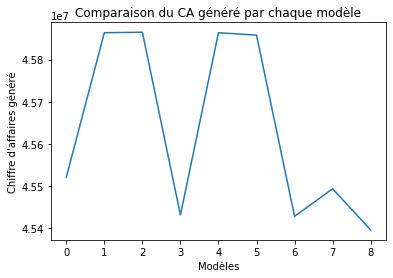

In [53]:
# Comparaison du CA généré par chaque modèle
dep = [dep8, dep9, dep10, dep11, dep12, dep13, dep14, CA_total, CA_total_nov]
plt.plot(dep)
plt.ylabel("Chiffre d'affaires généré")
plt.xlabel("Modèles")
plt.title("Comparaison du CA généré par chaque modèle") 
plt.show()

Les meilleurs modèles sont obtenus avec l'algorithme One Class SVM en utilisant les kernels polynomial et sigmoid.
Pour ces deux kernels, les résultats en outlier detection et novelty detection sont équivalents.